In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import proportional_hazard_test


We now run the Cox Model on the Test set with only those columns that we have selected in the training set.

In [31]:
testing_data= pd.read_csv("../Data Preparation/testing_data_50.csv")
important_train_columns = pd.read_csv("../Cox_Regression_training/important_columns.csv")

In [32]:
df = testing_data.copy()

In [33]:
imp_col = important_train_columns['Unnamed: 0'].to_list()

In [34]:
imp_col

['code_upd2101_cognitive_impairment',
 'code_upd2103_depressed_mood',
 'code_upd2108_pat_quest_daytime_sleepiness',
 'code_upd2111_pat_quest_constipation_problems',
 'code_upd2112_pat_quest_lightheadedness_on_standing',
 'code_upd2209_turning_in_bed',
 'code_upd2210_tremor',
 'code_upd2212_walking_and_balance',
 'code_upd2302_facial_expression',
 'code_upd2307a_right_toe_tapping',
 'code_upd2309_arising_from_chair',
 'code_upd2310_gait',
 'code_upd2313_posture',
 'code_upd2318_consistency_of_rest_tremor',
 'code_upd2hy_hoehn_and_yahr_stage',
 'upd2da_dyskinesias_during_exam_Yes',
 'upd23a_medication_for_pd_Yes']

In [35]:
df = df[['participant_id', 'visit_month', 'FOG', 'code_upd2101_cognitive_impairment',
 'code_upd2103_depressed_mood',
 'code_upd2108_pat_quest_daytime_sleepiness',
 'code_upd2111_pat_quest_constipation_problems',
 'code_upd2112_pat_quest_lightheadedness_on_standing',
 'code_upd2209_turning_in_bed',
 'code_upd2210_tremor',
 'code_upd2212_walking_and_balance',
 'code_upd2302_facial_expression',
 'code_upd2307a_right_toe_tapping',
 'code_upd2309_arising_from_chair',
 'code_upd2310_gait',
 'code_upd2313_posture',
 'code_upd2318_consistency_of_rest_tremor',
 'code_upd2hy_hoehn_and_yahr_stage', 'upd2da_dyskinesias_during_exam','upd23a_medication_for_pd' ]]

In [36]:

# 1. Drop identifier column
df = df.drop(columns=['participant_id'])
cardinality = 3
# 2. Convert categorical variables to dummy variables
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
high_cardinality_cols = [col for col in categorical_cols if df[col].nunique() > cardinality]
low_cardinality_cols = [col for col in categorical_cols if df[col].nunique() <= cardinality] 
# Drop them from the dataframe
df = df.drop(columns=high_cardinality_cols)

In [37]:


df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

# 3. Define duration and event columns
duration_col = 'visit_month'
event_col = 'FOG'


# 4. Initialize and fit Cox model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df, duration_col=duration_col, event_col=event_col)

# 5. Output results
results = cph.summary

In [38]:
results = results[results['p'] < 0.05]

In [39]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, code_upd2112_pat_quest_lightheadedness_on_standing to upd23a_medication_for_pd_Yes
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coef                 11 non-null     float64
 1   exp(coef)            11 non-null     float64
 2   se(coef)             11 non-null     float64
 3   coef lower 95%       11 non-null     float64
 4   coef upper 95%       11 non-null     float64
 5   exp(coef) lower 95%  11 non-null     float64
 6   exp(coef) upper 95%  11 non-null     float64
 7   cmp to               11 non-null     float64
 8   z                    11 non-null     float64
 9   p                    11 non-null     float64
 10  -log2(p)             11 non-null     float64
dtypes: float64(11)
memory usage: 1.0+ KB


In [40]:
results_ph = proportional_hazard_test(cph, df, time_transform='rank')

ph_test_df = results_ph.summary


ph_test_pass = ph_test_df[ph_test_df['p'] > 0.05]
ph_test_pass.info()



<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, code_upd2101_cognitive_impairment to upd2da_dyskinesias_during_exam_Yes
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   test_statistic  16 non-null     float64
 1   p               16 non-null     float64
 2   -log2(p)        16 non-null     float64
dtypes: float64(3)
memory usage: 512.0+ bytes


In [41]:
ph_test_pass.head()

,test_statistic,p,-log2(p)
code_upd2101_cognitive_impairment,0.156964,0.691967,0.531224
code_upd2108_pat_quest_daytime_sleepiness,0.002540,0.959805,0.059187
code_upd2111_pat_quest_constipation_problems,0.357660,0.549809,0.862998
code_upd2112_pat_quest_lightheadedness_on_standing,0.071874,0.788628,0.342583
code_upd2209_turning_in_bed,2.144305,0.143100,2.804906


In [42]:

significant_covariates = results.index

ph_ok_covariates = ph_test_pass.index

final_covariates = significant_covariates.intersection(ph_ok_covariates)




In [43]:
results_ph_ok = results.loc[final_covariates]

In [44]:
results_ph_ok.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, code_upd2112_pat_quest_lightheadedness_on_standing to upd23a_medication_for_pd_Yes
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coef                 11 non-null     float64
 1   exp(coef)            11 non-null     float64
 2   se(coef)             11 non-null     float64
 3   coef lower 95%       11 non-null     float64
 4   coef upper 95%       11 non-null     float64
 5   exp(coef) lower 95%  11 non-null     float64
 6   exp(coef) upper 95%  11 non-null     float64
 7   cmp to               11 non-null     float64
 8   z                    11 non-null     float64
 9   p                    11 non-null     float64
 10  -log2(p)             11 non-null     float64
dtypes: float64(11)
memory usage: 1.0+ KB


In [45]:
results_ph_ok.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, code_upd2112_pat_quest_lightheadedness_on_standing to upd23a_medication_for_pd_Yes
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   coef                 11 non-null     float64
 1   exp(coef)            11 non-null     float64
 2   se(coef)             11 non-null     float64
 3   coef lower 95%       11 non-null     float64
 4   coef upper 95%       11 non-null     float64
 5   exp(coef) lower 95%  11 non-null     float64
 6   exp(coef) upper 95%  11 non-null     float64
 7   cmp to               11 non-null     float64
 8   z                    11 non-null     float64
 9   p                    11 non-null     float64
 10  -log2(p)             11 non-null     float64
dtypes: float64(11)
memory usage: 1.0+ KB


In [52]:
print(results_ph_ok)

                                                        coef  exp(coef)  \
code_upd2112_pat_quest_lightheadedness_on_standing  0.089231   1.093333   
code_upd2209_turning_in_bed                         0.375079   1.455107   
code_upd2210_tremor                                 0.093297   1.097787   
code_upd2212_walking_and_balance                    0.241046   1.272580   
code_upd2302_facial_expression                      0.146825   1.158151   
code_upd2307a_right_toe_tapping                     0.081251   1.084643   
code_upd2309_arising_from_chair                     0.286988   1.332409   
code_upd2310_gait                                   0.101570   1.106907   
code_upd2318_consistency_of_rest_tremor            -0.055357   0.946148   
code_upd2hy_hoehn_and_yahr_stage                    0.182947   1.200751   
upd23a_medication_for_pd_Yes                        0.476864   1.611014   

                                                    se(coef)  coef lower 95%  \
code_upd2112_pat_qu

## Plotting the Kaplan Meier Curves

In [46]:
covariate_list = results_ph_ok.index.tolist()

In [47]:
testing_data = testing_data[['participant_id', 'visit_month', 'FOG', 'code_upd2112_pat_quest_lightheadedness_on_standing',
 'code_upd2209_turning_in_bed',
 'code_upd2210_tremor',
 'code_upd2212_walking_and_balance',
 'code_upd2302_facial_expression',
 'code_upd2307a_right_toe_tapping',
 'code_upd2309_arising_from_chair',
 'code_upd2310_gait',
 'code_upd2318_consistency_of_rest_tremor',
 'code_upd2hy_hoehn_and_yahr_stage',
 'upd23a_medication_for_pd']]

In [48]:
testing_data.nunique()

participant_id                                        1638
visit_month                                             17
FOG                                                      2
code_upd2112_pat_quest_lightheadedness_on_standing       5
code_upd2209_turning_in_bed                              5
code_upd2210_tremor                                      5
code_upd2212_walking_and_balance                         5
code_upd2302_facial_expression                           5
code_upd2307a_right_toe_tapping                          5
code_upd2309_arising_from_chair                          5
code_upd2310_gait                                        5
code_upd2318_consistency_of_rest_tremor                  5
code_upd2hy_hoehn_and_yahr_stage                         6
upd23a_medication_for_pd                                 2
dtype: int64

In [49]:
testing_data['upd23a_medication_for_pd'].unique()

array(['No', 'Yes'], dtype=object)

In [50]:
kmf = KaplanMeierFitter()

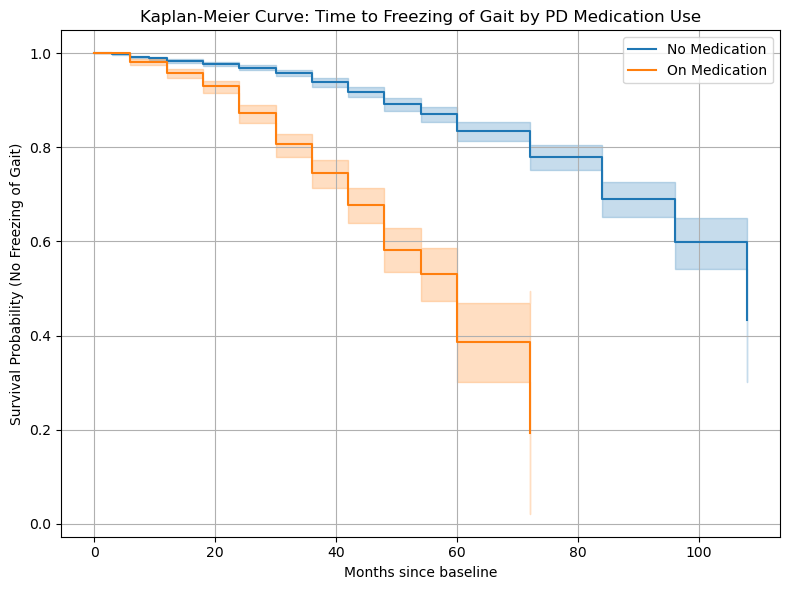

In [53]:
plt.figure(figsize=(8, 6))

# No medication group
kmf.fit(testing_data.loc[testing_data['upd23a_medication_for_pd'] == 'No', 'visit_month'],
        testing_data.loc[testing_data['upd23a_medication_for_pd'] == 'No', 'FOG'],
        label='No Medication')
ax = kmf.plot(ci_show=True)

# Yes medication group
kmf.fit(testing_data.loc[testing_data['upd23a_medication_for_pd'] == 'Yes', 'visit_month'],
        testing_data.loc[testing_data['upd23a_medication_for_pd'] == 'Yes', 'FOG'],
        label='On Medication')
kmf.plot(ax=ax, ci_show=True)

plt.title('Kaplan-Meier Curve: Time to Freezing of Gait by PD Medication Use')
plt.xlabel('Months since baseline')
plt.ylabel('Survival Probability (No Freezing of Gait)')
plt.grid(True)
plt.tight_layout()
plt.show()





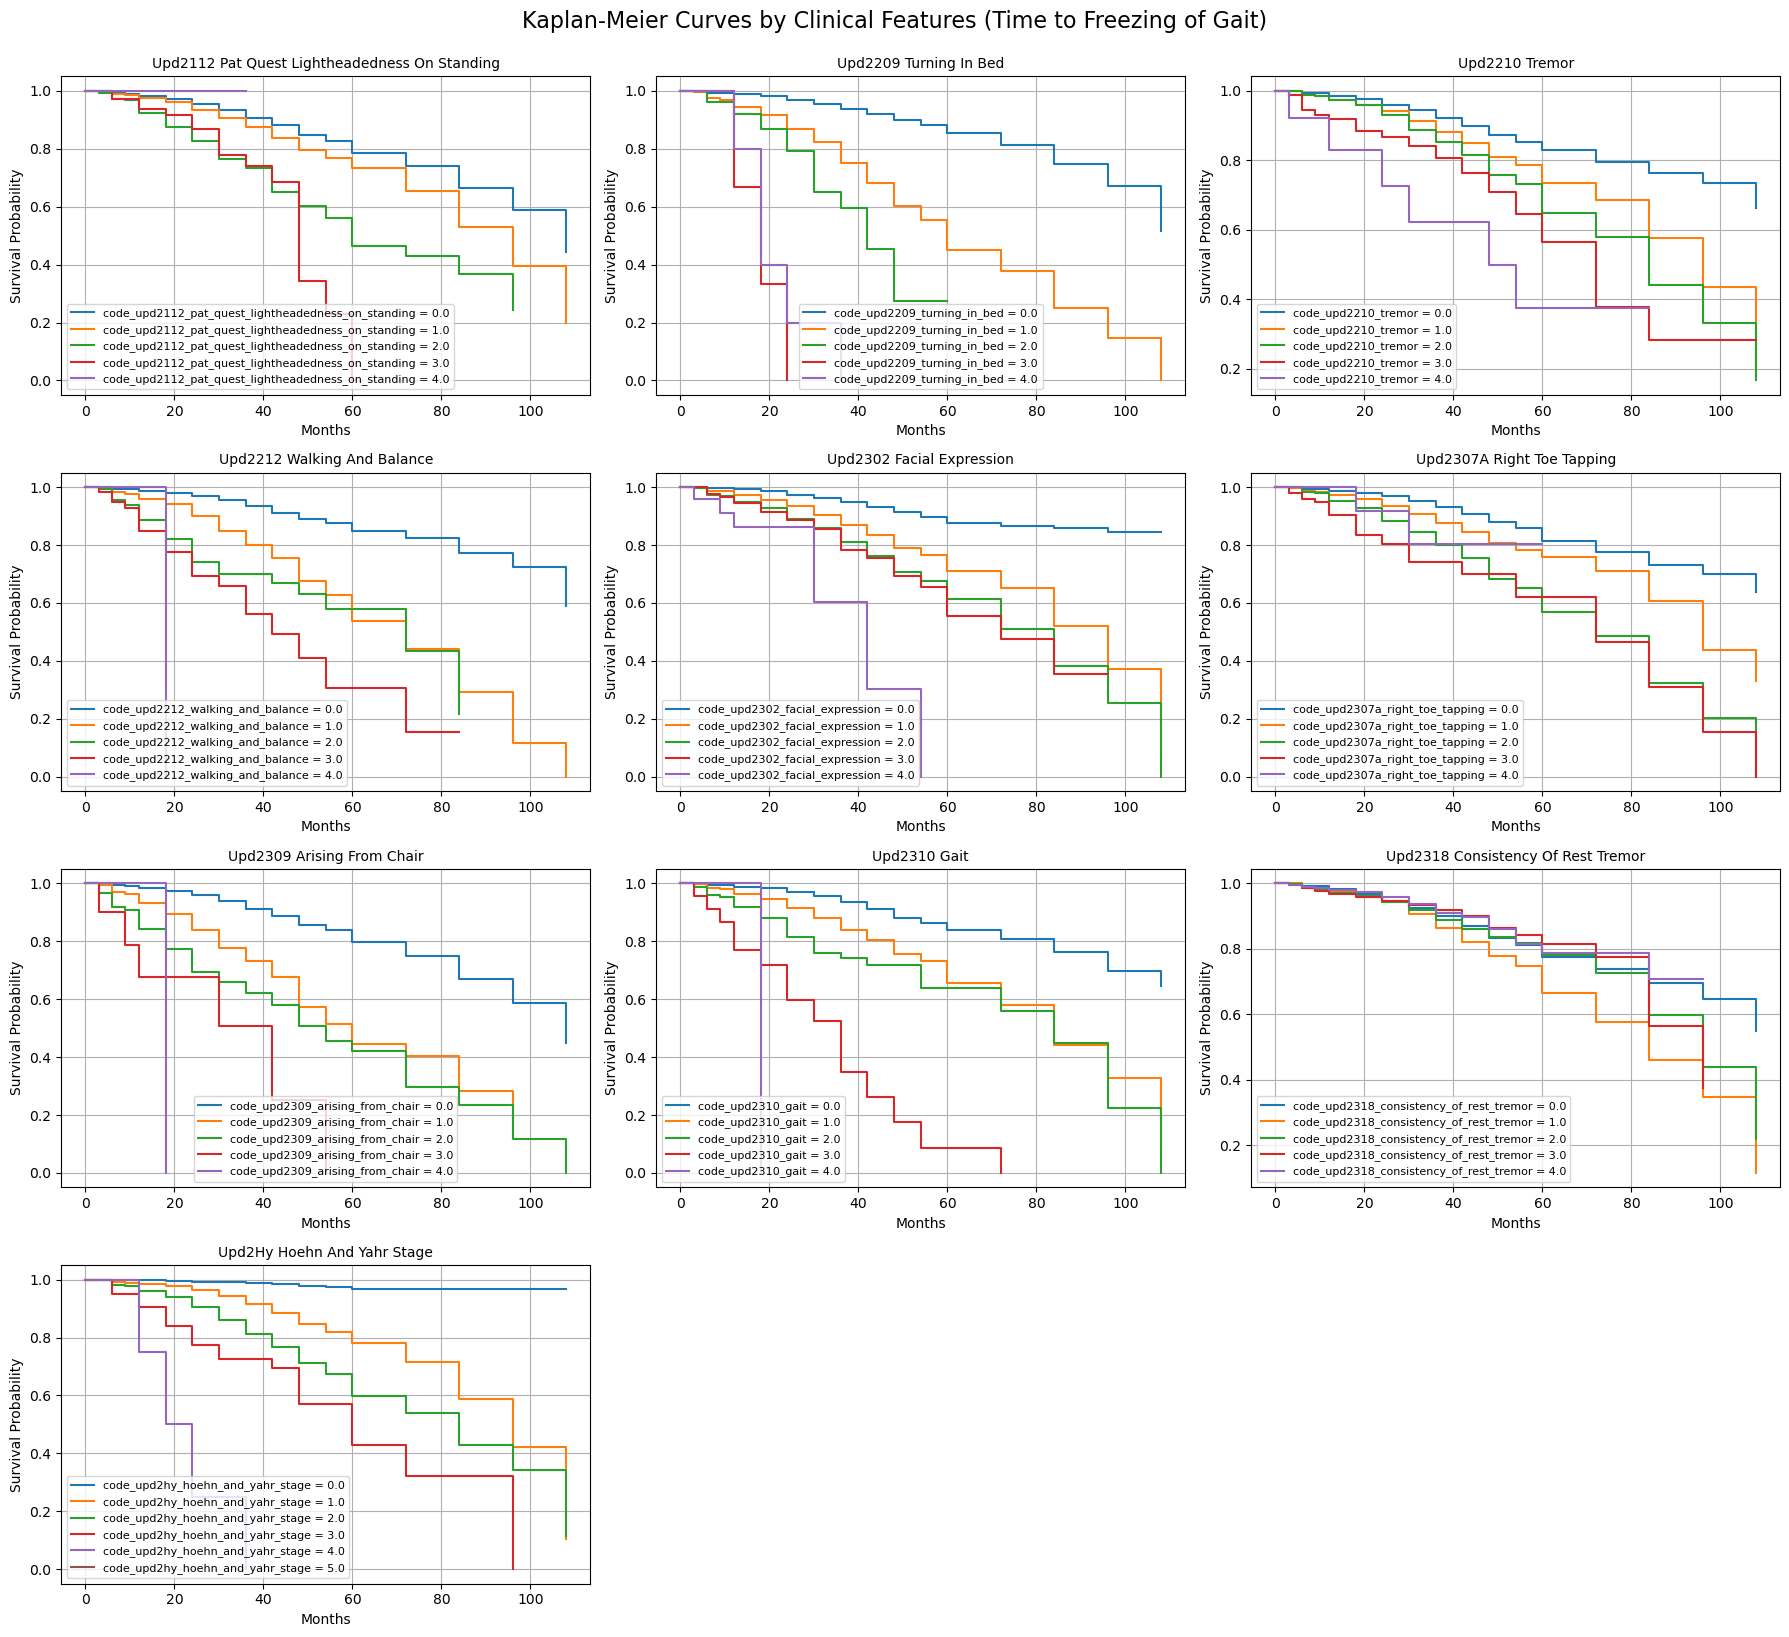

In [54]:
km_columns = [
    "code_upd2112_pat_quest_lightheadedness_on_standing",
    "code_upd2209_turning_in_bed",
    "code_upd2210_tremor",
    "code_upd2212_walking_and_balance",
    "code_upd2302_facial_expression",
    "code_upd2307a_right_toe_tapping",
    "code_upd2309_arising_from_chair",
    "code_upd2310_gait",
    "code_upd2318_consistency_of_rest_tremor",
    "code_upd2hy_hoehn_and_yahr_stage"
]

# Set up plot grid
n_cols = 3
n_rows = (len(km_columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), sharex=False, sharey=False)

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop over each variable
for i, col in enumerate(km_columns):
    ax = axes[i]
    kmf = KaplanMeierFitter()
    
    # Drop NA for current column
    sub_df = testing_data[[col, 'visit_month', 'FOG']].dropna()
    
    # Get sorted unique values (to group by)
    groups = sorted(sub_df[col].unique())

    # Plot a KM curve for each value of the current column
    for val in groups:
        mask = sub_df[col] == val
        kmf.fit(sub_df.loc[mask, 'visit_month'], sub_df.loc[mask, 'FOG'], label=f"{col} = {val}")
        kmf.plot(ax=ax, ci_show=False)

    ax.set_title(col.replace("code_", "").replace("_", " ").title(), fontsize=10)
    ax.set_xlabel('Months')
    ax.set_ylabel('Survival Probability')
    ax.grid(True)
    ax.legend(fontsize=8)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Kaplan-Meier Curves by Clinical Features (Time to Freezing of Gait)', y=1.02, fontsize=16)
plt.show()

